In [1]:
import tensorflow as tf

2023-10-16 01:45:42.367181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 01:45:42.554030: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 01:45:43.300409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-16 01:45:43.300494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
tf.__version__

'2.10.0'

In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [2]:
# we'll read both of these values and the original input and irrelevant tcrs
X_cdr3s = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
X_epitopes = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [3]:
# grab a subset
np.random.seed(0)
n_rows = 50000
perc_train = 0.75
# > subset target
idxs = np.random.choice(hit.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
# > subset control
idxs = np.random.choice(irr.index, size=n_rows, replace=False)
idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
print(len(idxs), len(idys))
irr_train, irr_test = irr.loc[idxs], irr.loc[idys]

37500 12500
37500 12500


In [4]:
# now that was the subset we are going to ignore, we'll now grab the rest of the data for formal testing
# so previously we used 75k inputs for training with 25k for testing

In [5]:
# > subset target
val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
print(len(val_idxs))
hit_val = hit.loc[val_idxs]
# > subset control
val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
print(len(val_idxs))
irr_val = irr.loc[val_idxs]

77014
38001


In [6]:
# create X for validation
X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
# combine
X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
X_val = X_val_cdr3s.join(X_val_epitopes)

# grab y for validation
y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])), pd.Series(np.zeros(irr_val.shape[0]))]).astype(int)
y_val = y_val.reset_index().iloc[:, 1:][0]

In [7]:
# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X_val = X_val[means.index]
# normalize
X_val -= means
X_val /= stds

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

%load_ext tensorboard

# now read in the keras model
model = keras.models.load_model('../outputs/model_v5/model_v5.keras')

2023-10-12 03:39:58.433878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 03:39:58.584016: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-12 03:39:59.214557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-12 03:39:59.214652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [9]:
# retrieve the appropriate columns
cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

In [10]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from tqdm import tqdm

# set seed for random subsets
np.random.seed(0)

# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

# test this for 10 random subsets of 10% of the data
n_rows = round(X_val.shape[0] * 0.10)
print('We are testing each validation round with', n_rows, 'rows')
for _ in range(10):
    # grab the random idxs
    idxs = np.random.choice(X_val.index, size=n_rows, replace=False)
    
    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3].loc[idxs], X_val[cols_ag].loc[idxs]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.loc[idxs].index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val.loc[idxs]], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))

We are testing each validation round with 11502 rows
360/360 [==============================] - 1s 2ms/step


[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

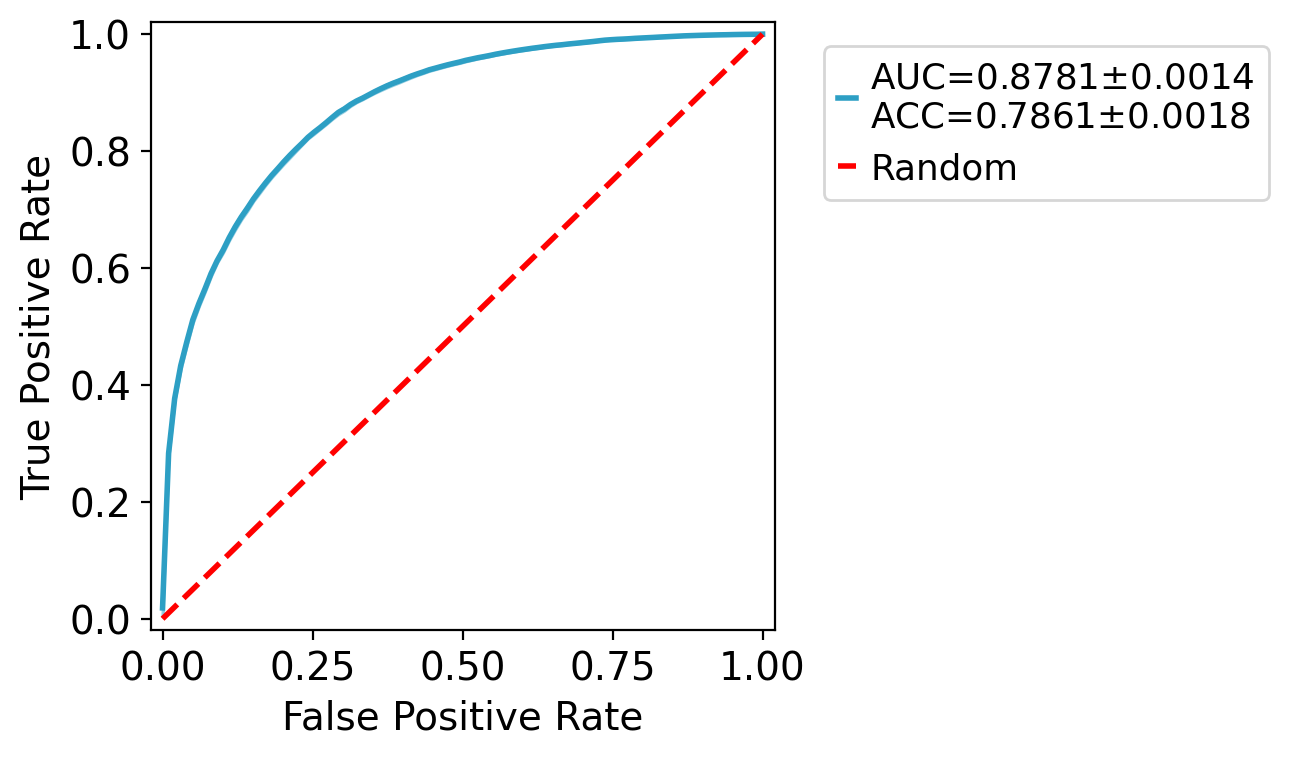

In [11]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

In [12]:
import time

# set seed for random subsets
np.random.seed(0)

# retrieve values and aucs
timings = pd.DataFrame(columns=['n_rows','total_time'])

# test for timings, we test 2000 increments but 5 rounds each to get good standard errors
n_rounds = 10
step_size = 2000
for round_num in range(n_rounds):
    for _ in range(5):
        # grab the random idxs
        idxs = np.random.choice(X_val.index, size=step_size*(round_num+1), replace=False)

        # testing predictions
        start_time = time.time()
        y_pred = model.predict([X_val[cols_cdr3].loc[idxs], X_val[cols_ag].loc[idxs]],
                               workers=1, use_multiprocessing=False)[:, 0]
        end_time = time.time()
        total_time = end_time - start_time

        # save data
        timings.loc[timings.shape[0]] = step_size*(round_num+1), total_time

625/625 [==============================] - 1s 2ms/step


(0.0, 2.7913446950912477)

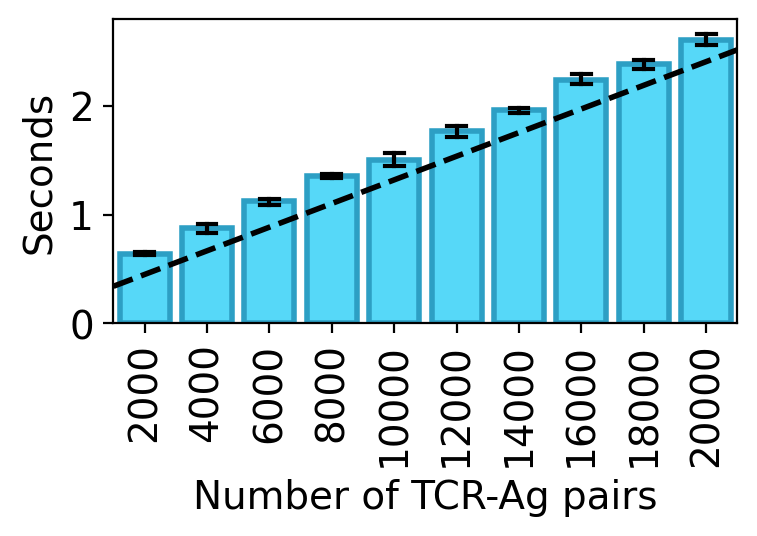

In [24]:
fig, ax = plt.subplots(figsize=[4, 2])
ax.grid(False)
timings['n_rows'] = timings['n_rows'].astype(int)
sns.barplot(x='n_rows', y='total_time', data=timings, color='#56D8F8', edgecolor='#2D9FC4', linewidth=2,
            errcolor='k', ci=95, errwidth=1.5, capsize=0.3, saturation=1)
ax.tick_params(axis='x', labelrotation=90)
ax.set(xlabel='Number of TCR-Ag pairs', ylabel='Seconds')
# solve for the equation
xlim, ylim = ax.get_xlim(), ax.get_ylim()
trend = np.polynomial.Polynomial(0).fit(timings['n_rows']/step_size, timings['total_time'], 1)
xs, ys = trend.linspace(domain=xlim)
ax.plot(xs, ys, linestyle='--', color='k', linewidth=2)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

In [19]:
# solve for the equation
np.polynomial.Polynomial(0).fit(timings['total_time'], timings['n_rows'], 1)

Polynomial([11101.18595639,  9524.46221014], domain=[0.61360741, 2.69690847], window=[-1.,  1.])

In [21]:
# calculate slope
9524.462210136517 * 0.9600148683943392

9143.625335191065